# Предсказание суммы ущерба для клиента

## Установка необходимых библиотек

In [4]:
!pip install -q kaggle
!pip install -q catboost

     |████████████████████████████████| 69.2MB 62kB/s 


In [5]:
import os
import catboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных и создание датасета

In [49]:
data = pd.read_csv('/content/car_insurance_claim_data.csv')

In [53]:
data.isna().sum()

KIDSDRIV        0
BIRTH           0
AGE             7
HOMEKIDS        0
YOJ           548
INCOME        570
PARENT1         0
HOME_VAL      575
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
CLAIM_FLAG      0
URBANICITY      0
dtype: int64

In [51]:
data.drop(columns=['ID'], inplace=True)

In [52]:
money_cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
for c in money_cols:
    data[c] = data[c].apply(lambda x: x if x is np.nan else int(x.strip('$').replace(',', '')))

In [25]:
data[data['AGE'].isna()]

,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
295,0,18FEB86,NaN,2,8.0,"$2,954",Yes,$0,z_No,z_F,<High School,Clerical,21,Private,"$3,100",9,Sports Car,yes,"$10,099",2,No,4,"$6,142",5.0,1,Highly Urban/ Urban
1317,0,21NOV83,NaN,3,0.0,$0,Yes,$0,z_No,M,Bachelors,Student,5,Commercial,"$1,500",10,Minivan,yes,$0,0,No,7,"$3,092",8.0,1,Highly Urban/ Urban
1651,0,18OCT84,NaN,2,0.0,$0,Yes,$0,z_No,z_F,<High School,Home Maker,23,Private,"$14,500",1,z_SUV,yes,$0,0,No,0,"$3,444",6.0,1,Highly Urban/ Urban
3749,0,17FEB86,NaN,2,0.0,NaN,Yes,$0,z_No,z_F,Bachelors,Home Maker,31,Private,"$3,180",11,Sports Car,yes,"$25,235",1,Yes,0,"$2,541",13.0,1,Highly Urban/ Urban
4365,0,15FEB84,NaN,3,12.0,"$16,227",No,NaN,Yes,M,z_High School,Student,39,Private,"$20,770",1,Van,yes,$0,0,No,6,"$5,640",1.0,1,Highly Urban/ Urban
4554,0,17AUG85,NaN,0,9.0,"$14,484",No,$0,z_No,z_F,<High School,Clerical,20,Private,"$2,950",10,Sports Car,yes,"$4,518",1,No,1,"$4,798",1.0,1,Highly Urban/ Urban
5227,0,03DEC87,NaN,0,0.0,$0,No,NaN,Yes,z_F,z_High School,Student,43,Private,"$2,600",10,z_SUV,yes,"$4,656",4,No,3,$0,1.0,0,z_Highly Rural/ Rural


Судя по данным, возраст не указан у лиц, младше 17 лет, вероятно, эти данные являются выбросами, удалим данные записи.

In [54]:
data['AGE'].dropna(inplace=True)

In [57]:
data['OCCUPATION'].value_counts()

z_Blue Collar    2288
Clerical         1590
Professional     1408
Manager          1257
Lawyer           1031
Student           899
Home Maker        843
Doctor            321
Name: OCCUPATION, dtype: int64

In [58]:
data['OCCUPATION'].fillna('z_Blue Collar', inplace=True)

In [69]:
oc_d = dict()
for oc in list(data['OCCUPATION'].unique()):
    oc_d[oc] = data[data['OCCUPATION'] == oc]['INCOME'].mean()

In [70]:
oc_d

{'Clerical': 33667.89347536618,
 'Doctor': 127561.31715210355,
 'Home Maker': 12393.16305732484,
 'Lawyer': 88336.59451219512,
 'Manager': 88067.3411567477,
 'Professional': 75971.8968373494,
 'Student': 6262.51497005988,
 'z_Blue Collar': 72030.66344778254}

In [75]:
for i in list(data.index[data['INCOME'].isna()]):
    data.loc[i, 'INCOME'] = oc_d[data.loc[i, 'OCCUPATION']]

In [76]:
data.isna().sum()

KIDSDRIV        0
BIRTH           0
AGE             7
HOMEKIDS        0
YOJ           548
INCOME          0
PARENT1         0
HOME_VAL      575
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION      0
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
CLAIM_FLAG      0
URBANICITY      0
dtype: int64

In [56]:
len(data[(data['INCOME'].isna()) & (data['OCCUPATION'].isna())])

34

In [81]:
data = data[data['CLM_AMT'] > 0]

In [89]:
data.isna().sum()

KIDSDRIV        0
BIRTH           0
AGE             0
HOMEKIDS        0
YOJ             6
INCOME          0
PARENT1         0
HOME_VAL      148
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION      0
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       175
CLAIM_FLAG      0
URBANICITY      0
RELATIVE        0
dtype: int64

Вычислим отношение стажа работы с возрастом.

In [88]:
data['AGE'] = 99 - data['BIRTH'].apply(lambda x: int(x[-2:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [90]:
data['RELATIVE'] = data['YOJ']/data['AGE']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [91]:
data['RELATIVE'].fillna(data['RELATIVE'].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [92]:
data['YOJ'] = data['AGE'] * data['RELATIVE']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
data.isna().sum()

KIDSDRIV      0
BIRTH         0
AGE           0
HOMEKIDS      0
YOJ           0
INCOME        0
PARENT1       0
HOME_VAL      0
MSTATUS       0
GENDER        0
EDUCATION     0
OCCUPATION    0
TRAVTIME      0
CAR_USE       0
BLUEBOOK      0
TIF           0
CAR_TYPE      0
RED_CAR       0
OLDCLAIM      0
CLM_FREQ      0
REVOKED       0
MVR_PTS       0
CLM_AMT       0
CAR_AGE       0
CLAIM_FLAG    0
URBANICITY    0
RELATIVE      0
dtype: int64

In [95]:
data['HOME_VAL'].fillna(data['HOME_VAL'].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [97]:
data['CAR_AGE'].fillna(data['CAR_AGE'].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [99]:
data.drop(columns=['RELATIVE', 'CLAIM_FLAG'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746 entries, 6 to 10293
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KIDSDRIV    2746 non-null   int64  
 1   BIRTH       2746 non-null   object 
 2   AGE         2746 non-null   int64  
 3   HOMEKIDS    2746 non-null   int64  
 4   YOJ         2746 non-null   float64
 5   INCOME      2746 non-null   float64
 6   PARENT1     2746 non-null   object 
 7   HOME_VAL    2746 non-null   float64
 8   MSTATUS     2746 non-null   object 
 9   GENDER      2746 non-null   object 
 10  EDUCATION   2746 non-null   object 
 11  OCCUPATION  2746 non-null   object 
 12  TRAVTIME    2746 non-null   int64  
 13  CAR_USE     2746 non-null   object 
 14  BLUEBOOK    2746 non-null   int64  
 15  TIF         2746 non-null   int64  
 16  CAR_TYPE    2746 non-null   object 
 17  RED_CAR     2746 non-null   object 
 18  OLDCLAIM    2746 non-null   int64  
 19  CLM_FREQ    2746 non-null 

In [1]:
data.to_csv('claims.csv')

NameError: ignored

## Работа с созданным датасетом

In [6]:
data = pd.read_csv('claims.csv', index_col=0)

In [7]:
data.drop('BIRTH', axis=1, inplace=True)

In [8]:
data.corr()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CLM_AMT,CAR_AGE
KIDSDRIV,1.000000,0.002478,0.473294,0.076510,0.051489,0.049479,-0.016268,0.032421,-0.010905,0.016758,0.020208,0.013285,0.019997,0.015887
AGE,0.002478,1.000000,-0.416497,0.173556,0.175196,0.205196,0.056469,0.152371,-0.025044,0.016023,0.017202,-0.051200,0.017498,0.149219
HOMEKIDS,0.473294,-0.416497,1.000000,0.057281,-0.103790,-0.057978,-0.041972,-0.082932,-0.002845,0.001565,-0.000682,0.040115,0.007140,-0.075329
YOJ,0.076510,0.173556,0.057281,1.000000,0.369222,0.303204,0.032060,0.159985,-0.017686,0.010531,-0.012124,-0.037932,0.019748,0.056435
INCOME,0.051489,0.175196,-0.103790,0.369222,1.000000,0.460125,0.034556,0.405056,-0.029061,0.000105,0.002941,-0.063183,0.042451,0.392485
HOME_VAL,0.049479,0.205196,-0.057978,0.303204,0.460125,1.000000,0.022100,0.198860,-0.023047,-0.001963,-0.011813,-0.078710,0.018767,0.161418
TRAVTIME,-0.016268,0.056469,-0.041972,0.032060,0.034556,0.022100,1.000000,0.008981,-0.015055,-0.007170,0.025160,0.019633,0.007112,0.050785
BLUEBOOK,0.032421,0.152371,-0.082932,0.159985,0.405056,0.198860,0.008981,1.000000,-0.003123,-0.025024,-0.011282,-0.032389,0.122559,0.180757
TIF,-0.010905,-0.025044,-0.002845,-0.017686,-0.029061,-0.023047,-0.015055,-0.003123,1.000000,-0.000910,0.023779,-0.015599,-0.008175,-0.011460
OLDCLAIM,0.016758,0.016023,0.001565,0.010531,0.000105,-0.001963,-0.007170,-0.025024,-0.000910,1.000000,0.401205,0.144558,0.001407,-0.000255


In [9]:
cat_cols = ['PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'URBANICITY']

## Анализ данных

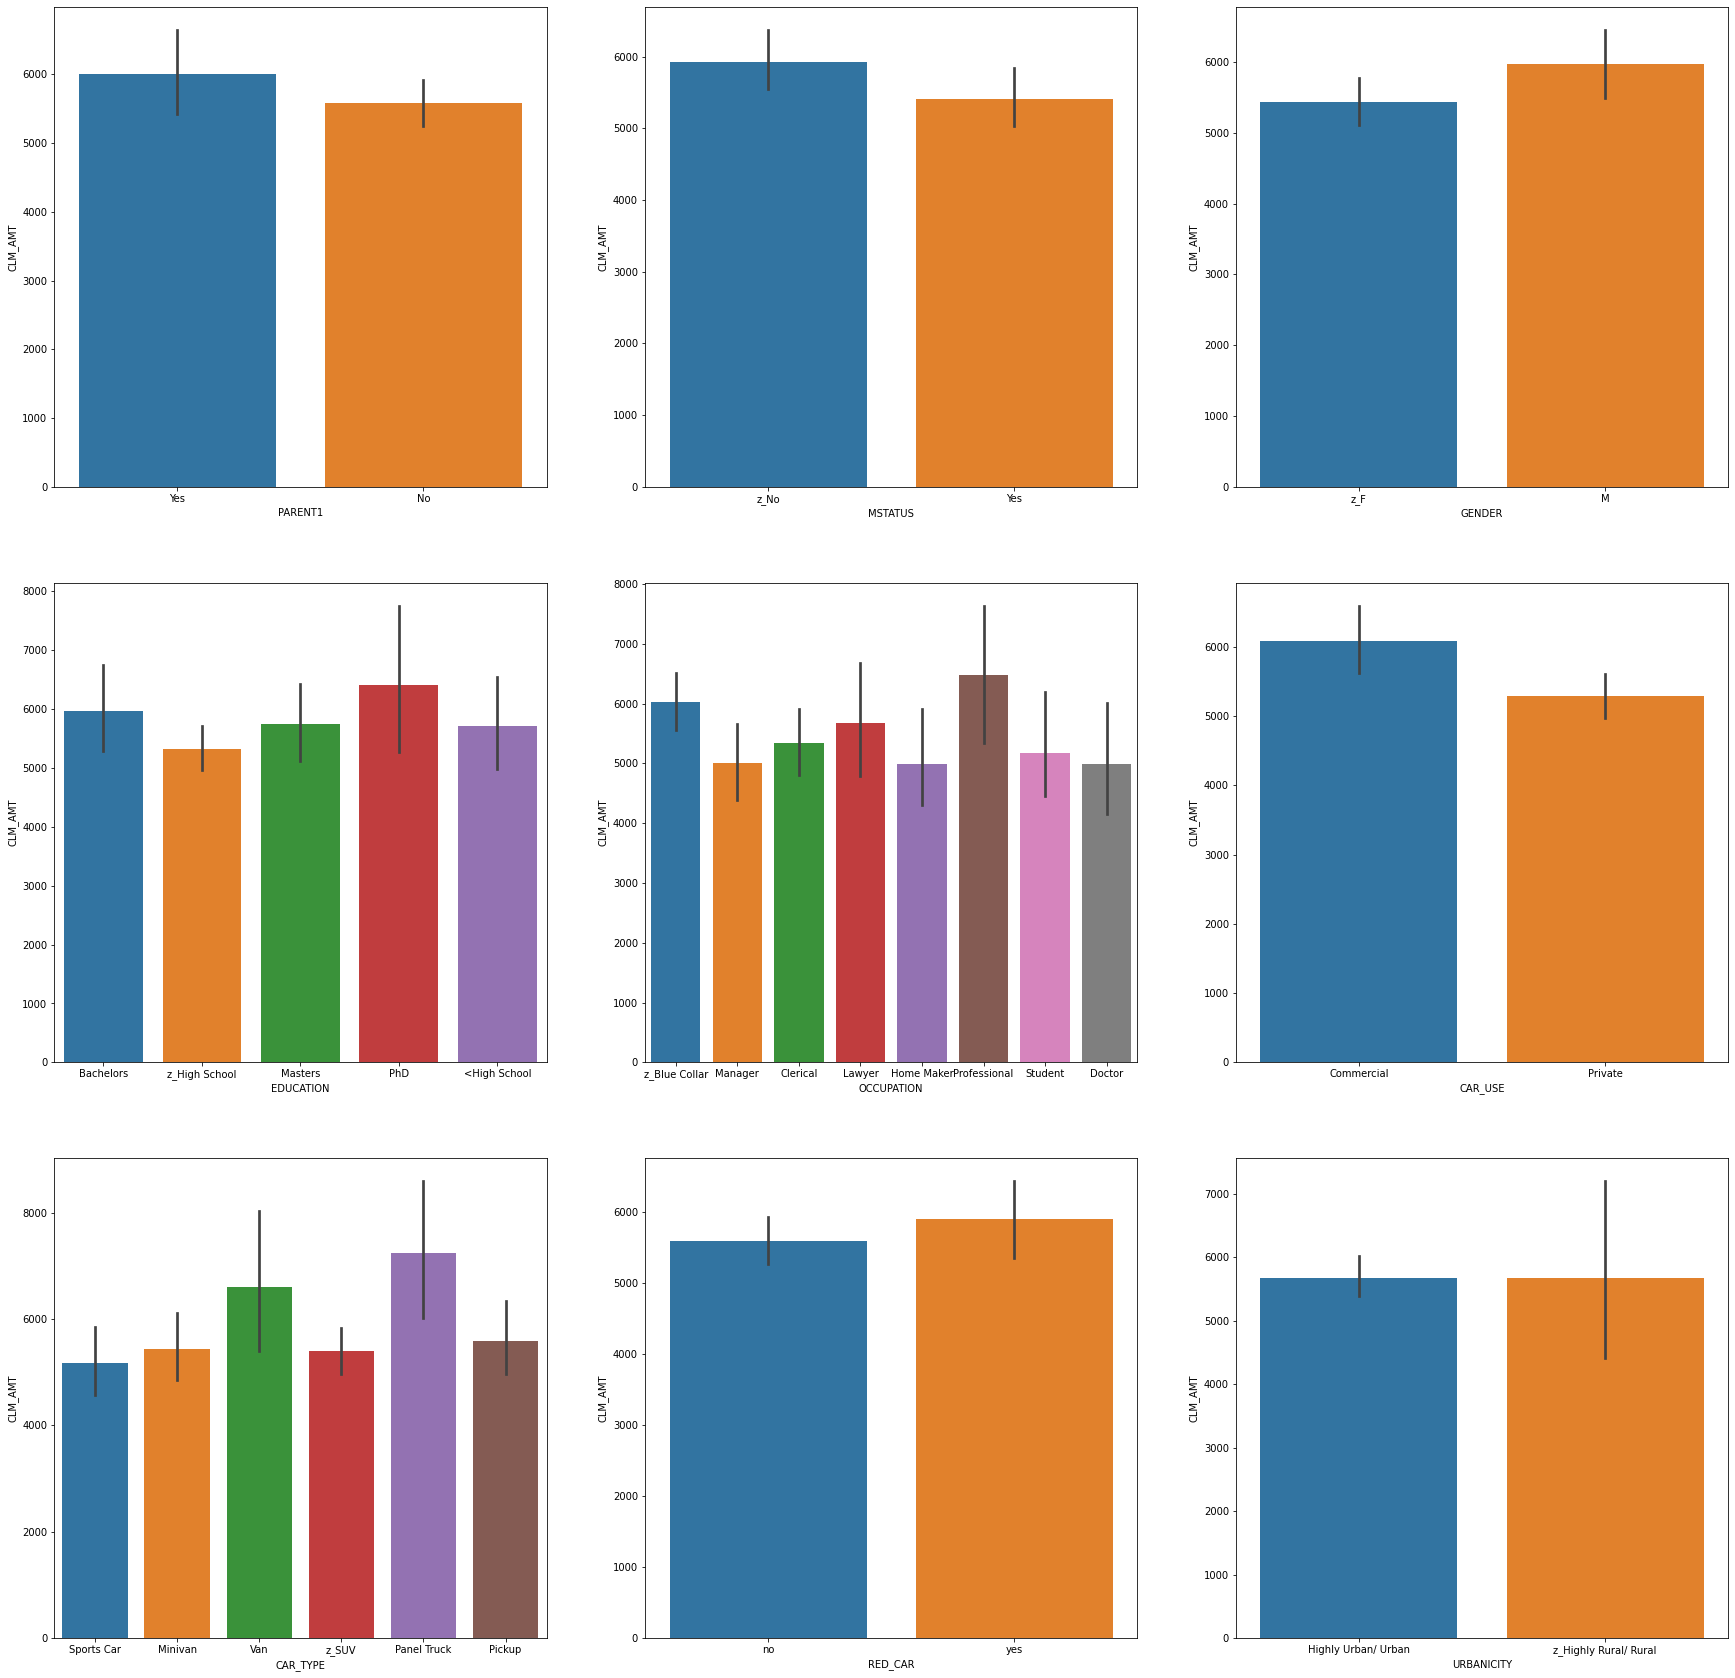

In [10]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(30, 30)
for i in range(9):
    r = i // 3
    c = i % 3
    sns.barplot(data=data, x=cat_cols[i], y='CLM_AMT', ax=ax[r][c])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746 entries, 6 to 10293
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KIDSDRIV    2746 non-null   int64  
 1   AGE         2746 non-null   int64  
 2   HOMEKIDS    2746 non-null   int64  
 3   YOJ         2746 non-null   float64
 4   INCOME      2746 non-null   float64
 5   PARENT1     2746 non-null   object 
 6   HOME_VAL    2746 non-null   float64
 7   MSTATUS     2746 non-null   object 
 8   GENDER      2746 non-null   object 
 9   EDUCATION   2746 non-null   object 
 10  OCCUPATION  2746 non-null   object 
 11  TRAVTIME    2746 non-null   int64  
 12  CAR_USE     2746 non-null   object 
 13  BLUEBOOK    2746 non-null   int64  
 14  TIF         2746 non-null   int64  
 15  CAR_TYPE    2746 non-null   object 
 16  RED_CAR     2746 non-null   object 
 17  OLDCLAIM    2746 non-null   int64  
 18  CLM_FREQ    2746 non-null   int64  
 19  REVOKED     2746 non-null 

## Обучение модели

In [12]:
reg = catboost.CatBoostRegressor(n_estimators=3000000, depth=1, loss_function='RMSE', learning_rate=1e-6, use_best_model=True)

In [13]:
X = data.drop('CLM_AMT', axis=1)
y = data['CLM_AMT']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [15]:
cat_cols.append('REVOKED')

In [16]:
reg.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_cols)

Выходные данные были обрезаны до нескольких последних строк (5000).
2995005:	learn: 8225.4246227	test: 6289.7222034	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.95s
2995006:	learn: 8225.4246087	test: 6289.7221927	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.95s
2995007:	learn: 8225.4246006	test: 6289.7221887	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.95s
2995008:	learn: 8225.4245877	test: 6289.7222006	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.95s
2995009:	learn: 8225.4245868	test: 6289.7221999	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.95s
2995010:	learn: 8225.4245771	test: 6289.7222076	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.95s
2995011:	learn: 8225.4245680	test: 6289.7222043	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.95s
2995012:	learn: 8225.4245618	test: 6289.7222079	best: 6289.3289510 (2355119)	total: 39m 29s	remaining: 3.94s
2995013:	learn: 8225.4245414	test: 6289.7222032	best: 6289.3

In [17]:
y_pred = reg.predict(X_test)

In [18]:
(y_pred - y_test).mean()

236.35893313941926

In [179]:
y_pred

array([5995.66254111, 6143.12816362, 6410.53108695, 5100.41912081,
       5726.14982505, 5712.73226486, 5318.53919943, 6157.35640132,
       5330.51793929, 4946.15661632, 6671.88926812, 5659.73580772,
       5027.69413527, 5939.44339098, 5760.78130892, 6433.11453   ,
       6194.35088679, 5769.98480344, 5027.2404417 , 5732.37669645,
       5018.80303506, 5263.64831664, 6287.64112068, 5771.10000901,
       5439.28974475, 6163.45079333, 5047.07080706, 6326.39299552,
       5020.86603803, 6236.44778352, 6013.25218092, 6138.85366746,
       6235.76875622, 5240.94043195, 6336.46168434, 5681.33067843,
       5015.2380047 , 5131.53112663, 5774.65419474, 5044.27818951,
       6426.3261325 , 5441.46810447, 4946.70347042, 5513.68549467,
       5156.82526804, 5052.44803442, 5334.61246787, 5146.71249042,
       4993.21490521, 5065.79549264, 5996.12739393, 5617.55813472,
       6482.15091613, 5763.6693038 , 6550.53634548, 6349.93560321,
       6707.54730097, 5684.39926991, 6354.61463635, 5559.41749

In [165]:
y_test

6963    5434
558     4257
7032    4666
4913    6005
9227    7099
        ... 
5672    4430
4119    3007
7998    4681
6254    3698
465     6228
Name: CLM_AMT, Length: 824, dtype: int64